In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
plt.style.use("seaborn-v0_8-poster")
plt.rcParams.update(
    {
        # Font settings for clarity and compatibility with academic publications
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "font.size": 14,  # Base font size for better readability
        "text.usetex": False,  # Enable LaTeX for text rendering for a professional look
        # Figure aesthetics & size for detailed visuals and fit on publication pages
        "figure.figsize": [8, 4],  # Default figure size
        "figure.facecolor": "white",  # White figure background for clean print
        "figure.autolayout": True,  # Automatic layout adjustments
        "figure.dpi": 400,  # High resolution figures for publication quality
        "savefig.dpi": 400,  # High resolution saving settings
        "savefig.format": "pdf",  # Save figures in PDF format for publications
        "savefig.bbox": "tight",  # Tight bounding box around figures
        # title, xlabel and ylabel bold
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        # Axes aesthetics for clarity and precision
        "axes.labelsize": 12,
        "axes.titlesize": 18,  # Prominent titles for immediate recognition
        "axes.facecolor": "white",  # White axes background
        "axes.grid": True,  # Enable grid for better readability
        "axes.spines.top": False,  # Disable top spine for aesthetic purposes
        "axes.spines.right": False,  # Disable right spine for aesthetic purposes
        "axes.formatter.limits": (0, 5),  # Threshold for scientific notation
        "axes.formatter.use_mathtext": True,  # Use mathtext for scientific notations
        "axes.formatter.useoffset": False,  # Disable offset on axes
        "axes.xmargin": 0,  # No margin around x-axis
        "axes.ymargin": 0,  # No margin around y-axis
        # Legend aesthetics
        "legend.fontsize": 12,
        "legend.frameon": False,  # No frame around legend for cleaner look
        "legend.loc": "best",  # Optimal legend positioning
        # Line aesthetics
        "lines.linewidth": 2,  # Thicker lines for visibility
        "lines.markersize": 8,  # Slightly smaller markers for balance
        # Tick aesthetics
        "xtick.labelsize": 12,
        "xtick.direction": "in",  # Ticks inside the plot
        "xtick.top": False,  # Disable top ticks for aesthetic purposes
        "ytick.labelsize": 12,
        "ytick.direction": "in",  # Ticks inside the plot
        "ytick.right": False,  # Disable right ticks for aesthetic purposes
        # Grid settings
        "grid.color": "grey",  # Grid color
        "grid.linestyle": "--",  # Dashed grid lines
        "grid.linewidth": 0.5,  # Thin grid lines
        # Error bar aesthetics
        "errorbar.capsize": 4,  # Error bar cap length
        # Layout settings
        "figure.subplot.wspace": 0.4,  # Adjust horizontal spacing between subplots
        "figure.subplot.hspace": 0.4,  # Adjust vertical spacing between subplots
        # Latex and color map settings
        "image.cmap": "viridis",  # Preferred color map for images
        "text.latex.preamble": r"\usepackage{amsmath}",  # Latex preamble for math expressions
    }
)

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device setup for CUDA or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


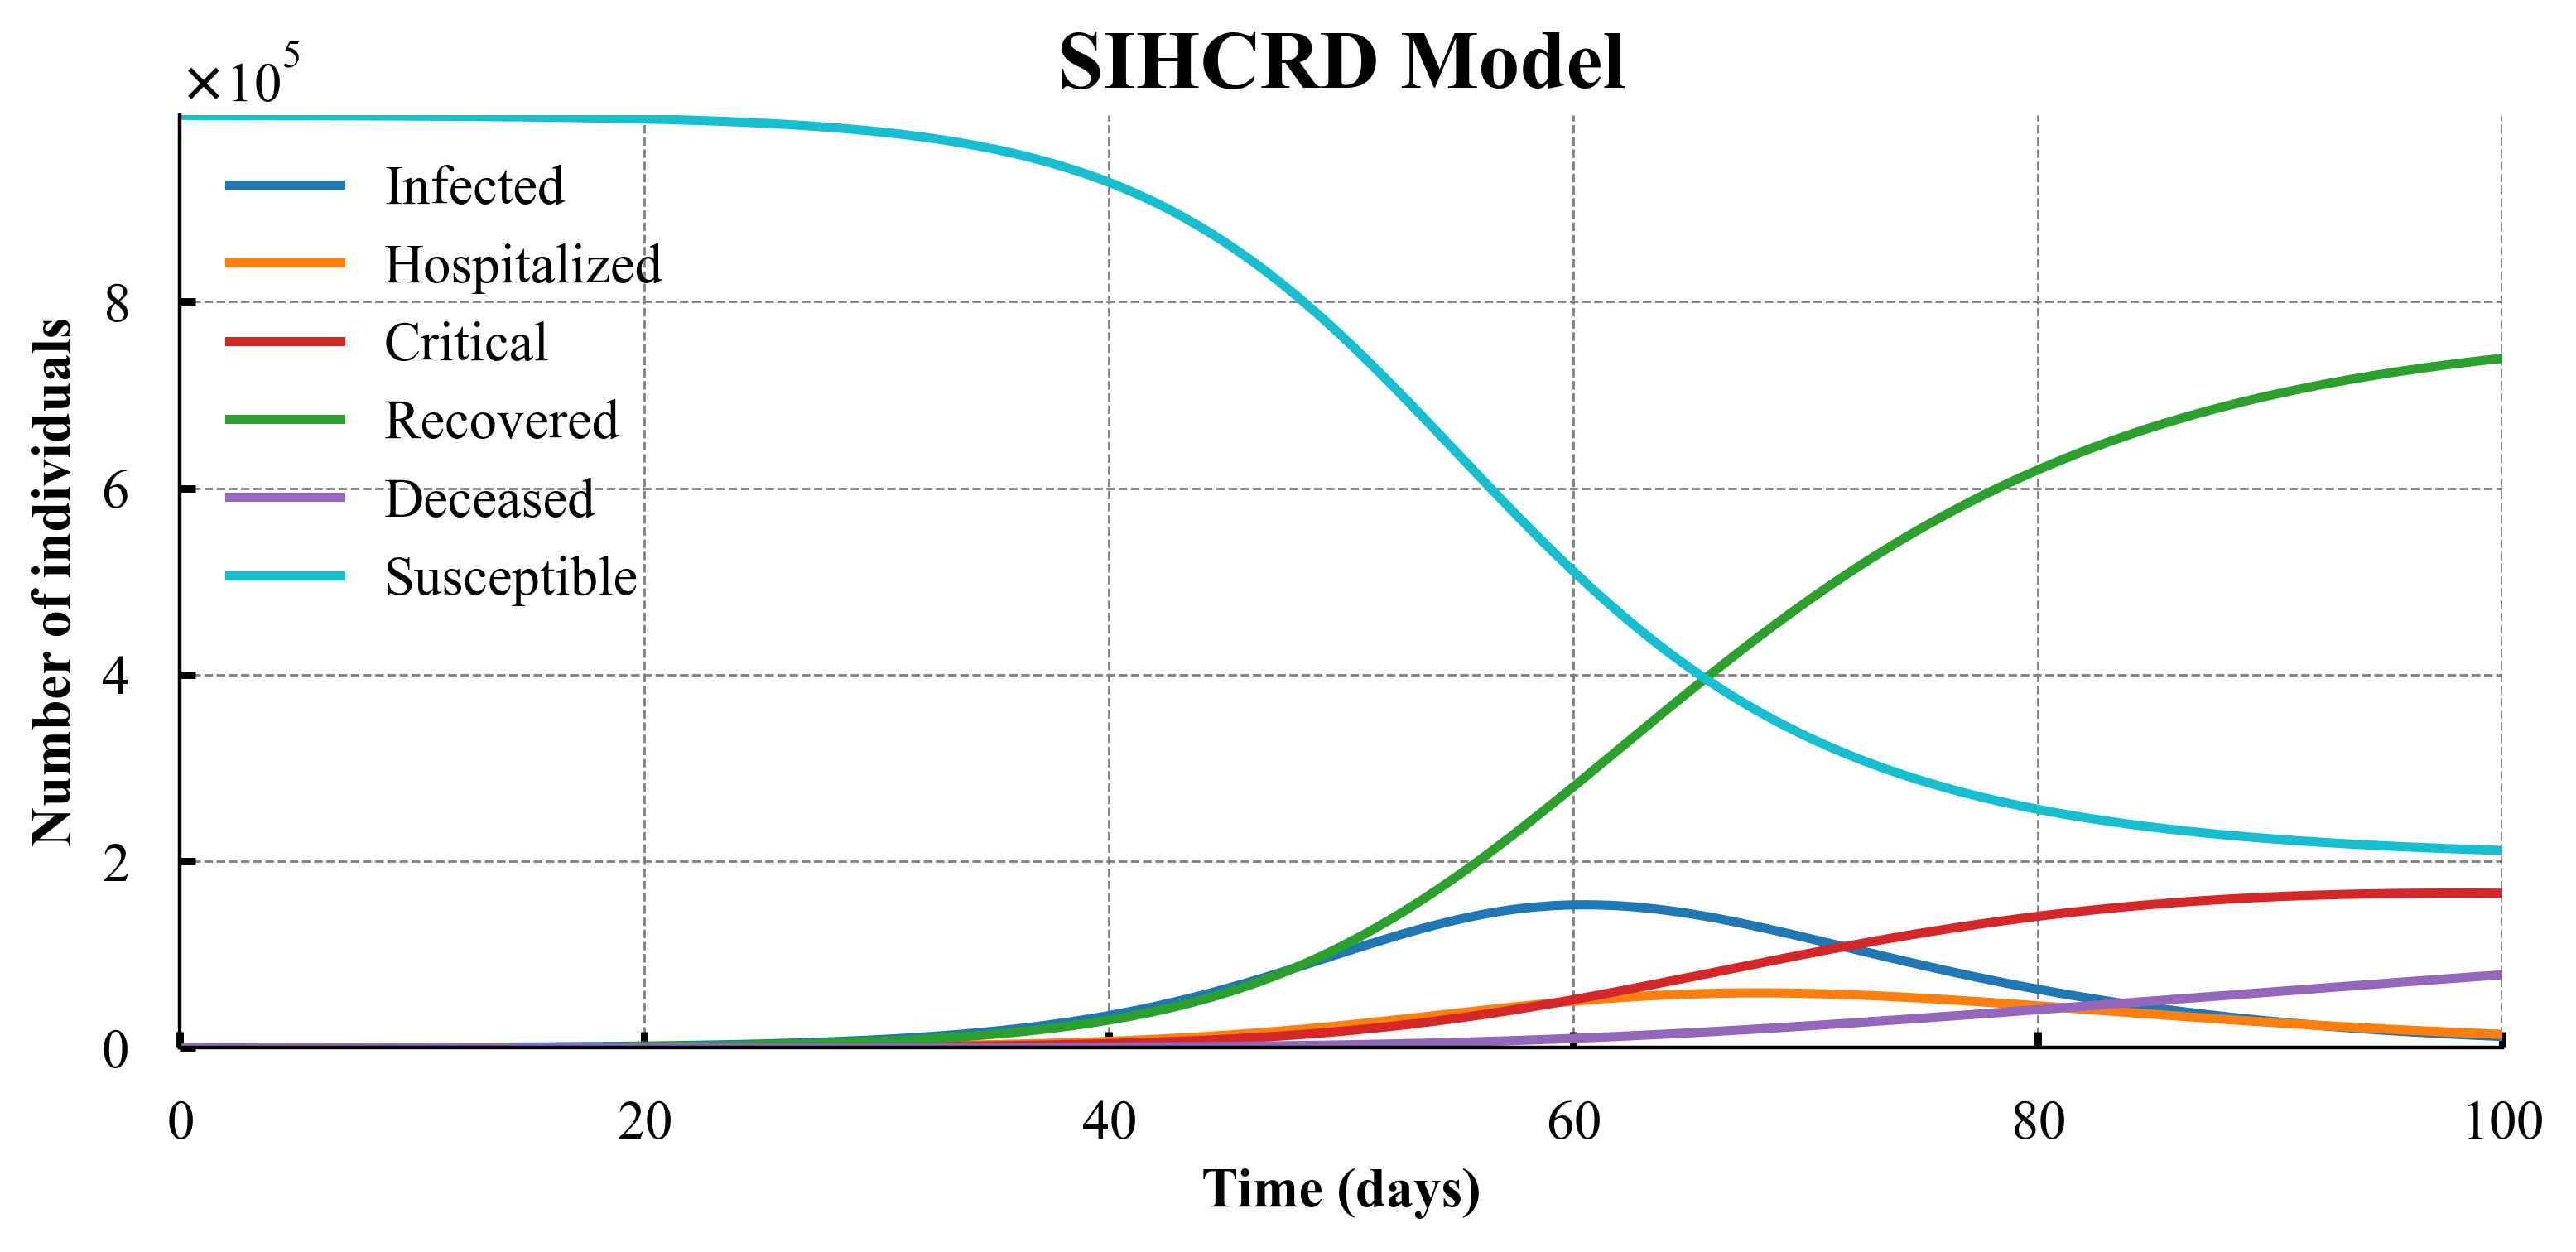

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# N is the total population
def SIHCRD_model(t, y, beta, gamma, delta, alpha, N):
    """
    Define the SIHCRD model as a system of differential equations.

    Parameters:
    - t: Time variable.
    - y: State variables [S, I, H, C, R, D].
    - beta: Infection rate.
    - gamma: Recovery rate.
    - delta: Death rate.
    - alpha: Hospitalization rate.
    - N: Total population.

    Returns:
    - A list of the derivatives for each state variable.
    """
    S, I, H, C, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + alpha) * I
    dHdt = alpha * I - (gamma + delta) * H
    dCdt = gamma * H - delta * C
    dRdt = gamma * (H + I)
    dDdt = delta * (H + C)
    return [dSdt, dIdt, dHdt, dCdt, dRdt, dDdt]


# Define the initial conditions
def initial_conditions(N, I0, H0, C0, R0, D0):
    """
    Define the initial conditions for the SIHCRD model.

    Parameters:
    - N: Total population.
    - I0: Initial number of infected individuals.
    - H0: Initial number of hospitalized individuals.
    - C0: Initial number of critical individuals.
    - R0: Initial number of recovered individuals.
    - D0: Initial number of deceased individuals.

    Returns:
    - A list of the initial conditions for each state variable.
    """
    S0 = N - I0 - H0 - C0 - R0 - D0
    return [S0, I0, H0, C0, R0, D0]


# Define the time span
t0 = 0
tf = 100

# Define the parameters
N = 1e6
I0 = 100
H0 = 0
C0 = 0
R0 = 0
D0 = 0
beta = 0.3
gamma = 0.1
delta = 0.01
alpha = 0.05

# Define the initial conditions
y0 = initial_conditions(N, I0, H0, C0, R0, D0)

# Solve the system of differential equations
sol = solve_ivp(
    SIHCRD_model,
    [t0, tf],
    y0,
    args=(beta, gamma, delta, alpha, N),
    dense_output=True,
)

# Extract the solution
t = np.linspace(t0, tf, 1000)
y = sol.sol(t)

# Plot the solution
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, y[1], label="Infected", color="tab:blue")
ax.plot(t, y[2], label="Hospitalized", color="tab:orange")
ax.plot(t, y[3], label="Critical", color="tab:red")
ax.plot(t, y[4], label="Recovered", color="tab:green")
ax.plot(t, y[5], label="Deceased", color="tab:purple")
ax.plot(t, y[0], label="Susceptible", color="tab:cyan")  # Add susceptible population
ax.set_xlabel("Time (days)")
ax.set_ylabel("Number of individuals")
ax.set_title("SIHCRD Model")
ax.legend()
plt.show()

In [4]:
df = pd.read_csv("../data/processed/england_data.csv").drop(
    columns=["Unnamed: 0"], axis=1
)

df.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName
0,2020-04-01,0.0,31201,15544.0,4382,3989.0,694.0,35571.0,4730.0,56171302,England
1,2020-04-02,1878.0,35138,15364.0,3937,3895.0,725.0,39466.0,5455.0,56171302,England
2,2020-04-03,2261.0,38526,18158.0,3388,3878.0,737.0,43344.0,6192.0,56171302,England
3,2020-04-04,2458.0,41972,20489.0,3446,3260.0,828.0,46604.0,7020.0,56171302,England
4,2020-04-05,2650.0,45418,22051.0,3446,2994.0,823.0,49598.0,7843.0,56171302,England


In [5]:
def load_and_preprocess_data(
    filepath, recovery_period=16, rolling_window=7, start_date="2020-04-01"
):
    """
    Load and preprocess the COVID-19 dataset for the SIHCRD model.

    Parameters:
    - filepath: Path to the CSV file containing the data.
    - recovery_period: Assumed number of days for recovery. Defaults to 16 days.
    - rolling_window: Window size for rolling average calculation. Defaults to 7 days.
    - start_date: The start date for filtering the data. Format 'YYYY-MM-DD'.

    Returns:
    - A preprocessed pandas DataFrame suitable for SIHCRD model integration.
    """
    df = pd.read_csv(filepath)

    # Ensure the dataset has the required columns
    required_columns = [
        "date",
        "cumulative_confirmed",
        "cumulative_deceased",
        "population",
        "covidOccupiedMVBeds",
        "hospitalCases",
    ]
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert date to datetime and calculate days since start
    df["date"] = pd.to_datetime(df["date"])
    df["days_since_start"] = (df["date"] - pd.to_datetime(start_date)).dt.days

    # # Data Quality Checks for cumulative data
    # for col in ["cumulative_confirmed", "cumulative_deceased"]:
    #     if df[col].isnull().any() or (df[col].diff().dropna() < 0).any():
    #         raise ValueError(f"Inconsistent data in column: {col}")

    # Calculate recovered cases assuming a fixed recovery period
    df["recovered"] = df["cumulative_confirmed"].shift(recovery_period) - df[
        "cumulative_deceased"
    ].shift(recovery_period)
    df["recovered"] = df["recovered"].fillna(0).clip(lower=0)

    # Calculate active cases
    df["active_cases"] = (
        df["cumulative_confirmed"] - df["recovered"] - df["cumulative_deceased"]
    )

    # Estimate the susceptible population
    df["S(t)"] = (
        df["population"]
        - df["active_cases"]
        - df["recovered"]
        - df["cumulative_deceased"]
    )

    # Apply rolling average
    for col in [
        "cumulative_confirmed",
        "cumulative_deceased",
        "hospitalCases",
        "covidOccupiedMVBeds",
        "recovered",
        "active_cases",
        "new_deceased",
    ]:
        df[col] = df[col].rolling(window=rolling_window, min_periods=1).mean().fillna(0)

    # Filter data based on the start date
    df = df[df["date"] >= pd.to_datetime(start_date)].reset_index(drop=True)

    # Ensure no negative values
    df[["recovered", "active_cases", "S(t)"]] = df[
        ["recovered", "active_cases", "S(t)"]
    ].clip(lower=0)

    return df


def split_time_series_data(df, train_size=0.7, val_size=0.15, test_size=0.15):
    """

    Splits the DataFrame into training, validation, and test sets while maintaining the time series order.


    Args:

        df (pd.DataFrame): The input DataFrame with time series data.

        train_size (float): Proportion of the dataset to allocate to training.

        val_size (float): Proportion of the dataset to allocate to validation.

        test_size (float): Proportion of the dataset to allocate to testing.


    Returns:

        tuple: Three DataFrames corresponding to the training, validation, and test sets.
    """

    if not np.isclose(train_size + val_size + test_size, 1.0):

        raise ValueError("train_size, val_size, and test_size should sum to 1.")

    n = len(df)

    train_end = int(n * train_size)

    val_end = train_end + int(n * val_size)

    train_data = df.iloc[:train_end]

    val_data = df.iloc[train_end:val_end]

    test_data = df.iloc[val_end:]

    return train_data, val_data, test_data

In [6]:
data = load_and_preprocess_data(
    "../data/processed/england_data.csv",
    recovery_period=21,
    rolling_window=7,
    start_date="2020-04-02",
).drop(columns=["Unnamed: 0"], axis=1)


# # split data

# train_data, val_data, test_data = split_time_series_data(data, train_size=0.7, val_size=0.15, test_size=0.15)


# train_data = train_data.head(100)

data.head()

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,areaName,days_since_start,recovered,active_cases,S(t)
0,2020-04-02,939.000000,35138,15454.000000,3937,3895.0,709.500000,37518.500000,5092.500000,56171302,England,0,0.0,32426.000000,56131836.0
1,2020-04-03,1379.666667,38526,16355.333333,3388,3878.0,718.666667,39460.333333,5459.000000,56171302,England,1,0.0,34001.333333,56127958.0
2,2020-04-04,1649.250000,41972,17388.750000,3446,3260.0,746.000000,41246.250000,5849.250000,56171302,England,2,0.0,35397.000000,56124698.0
3,2020-04-05,1849.400000,45418,18321.200000,3446,2994.0,761.400000,42916.600000,6248.000000,56171302,England,3,0.0,36668.600000,56121704.0
4,2020-04-06,2022.500000,48940,19023.166667,3522,4170.0,767.000000,44725.166667,6646.333333,56171302,England,4,0.0,38078.833333,56117534.0


In [7]:
train_data_start = "2020-05-01"
train_data_end = "2020-08-31"

val_data_start = "2020-09-01"
val_data_end = "2020-10-31"

t_mask = (data["date"] >= train_data_start) & (data["date"] <= train_data_end)
train_data = data.loc[t_mask]

v_mask = (data["date"] >= val_data_start) & (data["date"] <= val_data_end)
val_data = data.loc[v_mask]

In [8]:
def prepare_tensors(data, device):
    # t should be the length of the data starting from 1
    t = (
        torch.tensor(range(1, len(data) + 1), dtype=torch.float32)
        .view(-1, 1)
        .to(device)
        .requires_grad_(True)
    )
    # S = torch.tensor(data["S(t)"].values, dtype=torch.float32).view(-1, 1).to(device)
    I = (
        torch.tensor(data["active_cases"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    R = (
        torch.tensor(data["recovered"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    D = (
        torch.tensor(data["new_deceased"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    H = (
        torch.tensor(data["hospitalCases"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    C = (
        torch.tensor(data["covidOccupiedMVBeds"].values, dtype=torch.float32)
        .view(-1, 1)
        .to(device)
    )
    return t, I, R, D, H, C


features = [
    "S(t)",
    "active_cases",
    "hospitalCases",
    "covidOccupiedMVBeds",
    "recovered",
    "new_deceased",
]

In [9]:
scaler = MinMaxScaler()
scaler.fit(train_data[features])

scaled_train_data = pd.DataFrame(
    scaler.transform(train_data[features]), columns=features
)
scaled_val_data = pd.DataFrame(scaler.transform(val_data[features]), columns=features)


t_train, I_train, R_train, D_train, H_train, C_train = prepare_tensors(
    scaled_train_data, device
)

t_val, I_val, R_val, D_val, H_val, C_val = prepare_tensors(scaled_val_data, device)

tensor_data = torch.cat([I_train, H_train, C_train, R_train, D_train], dim=1)

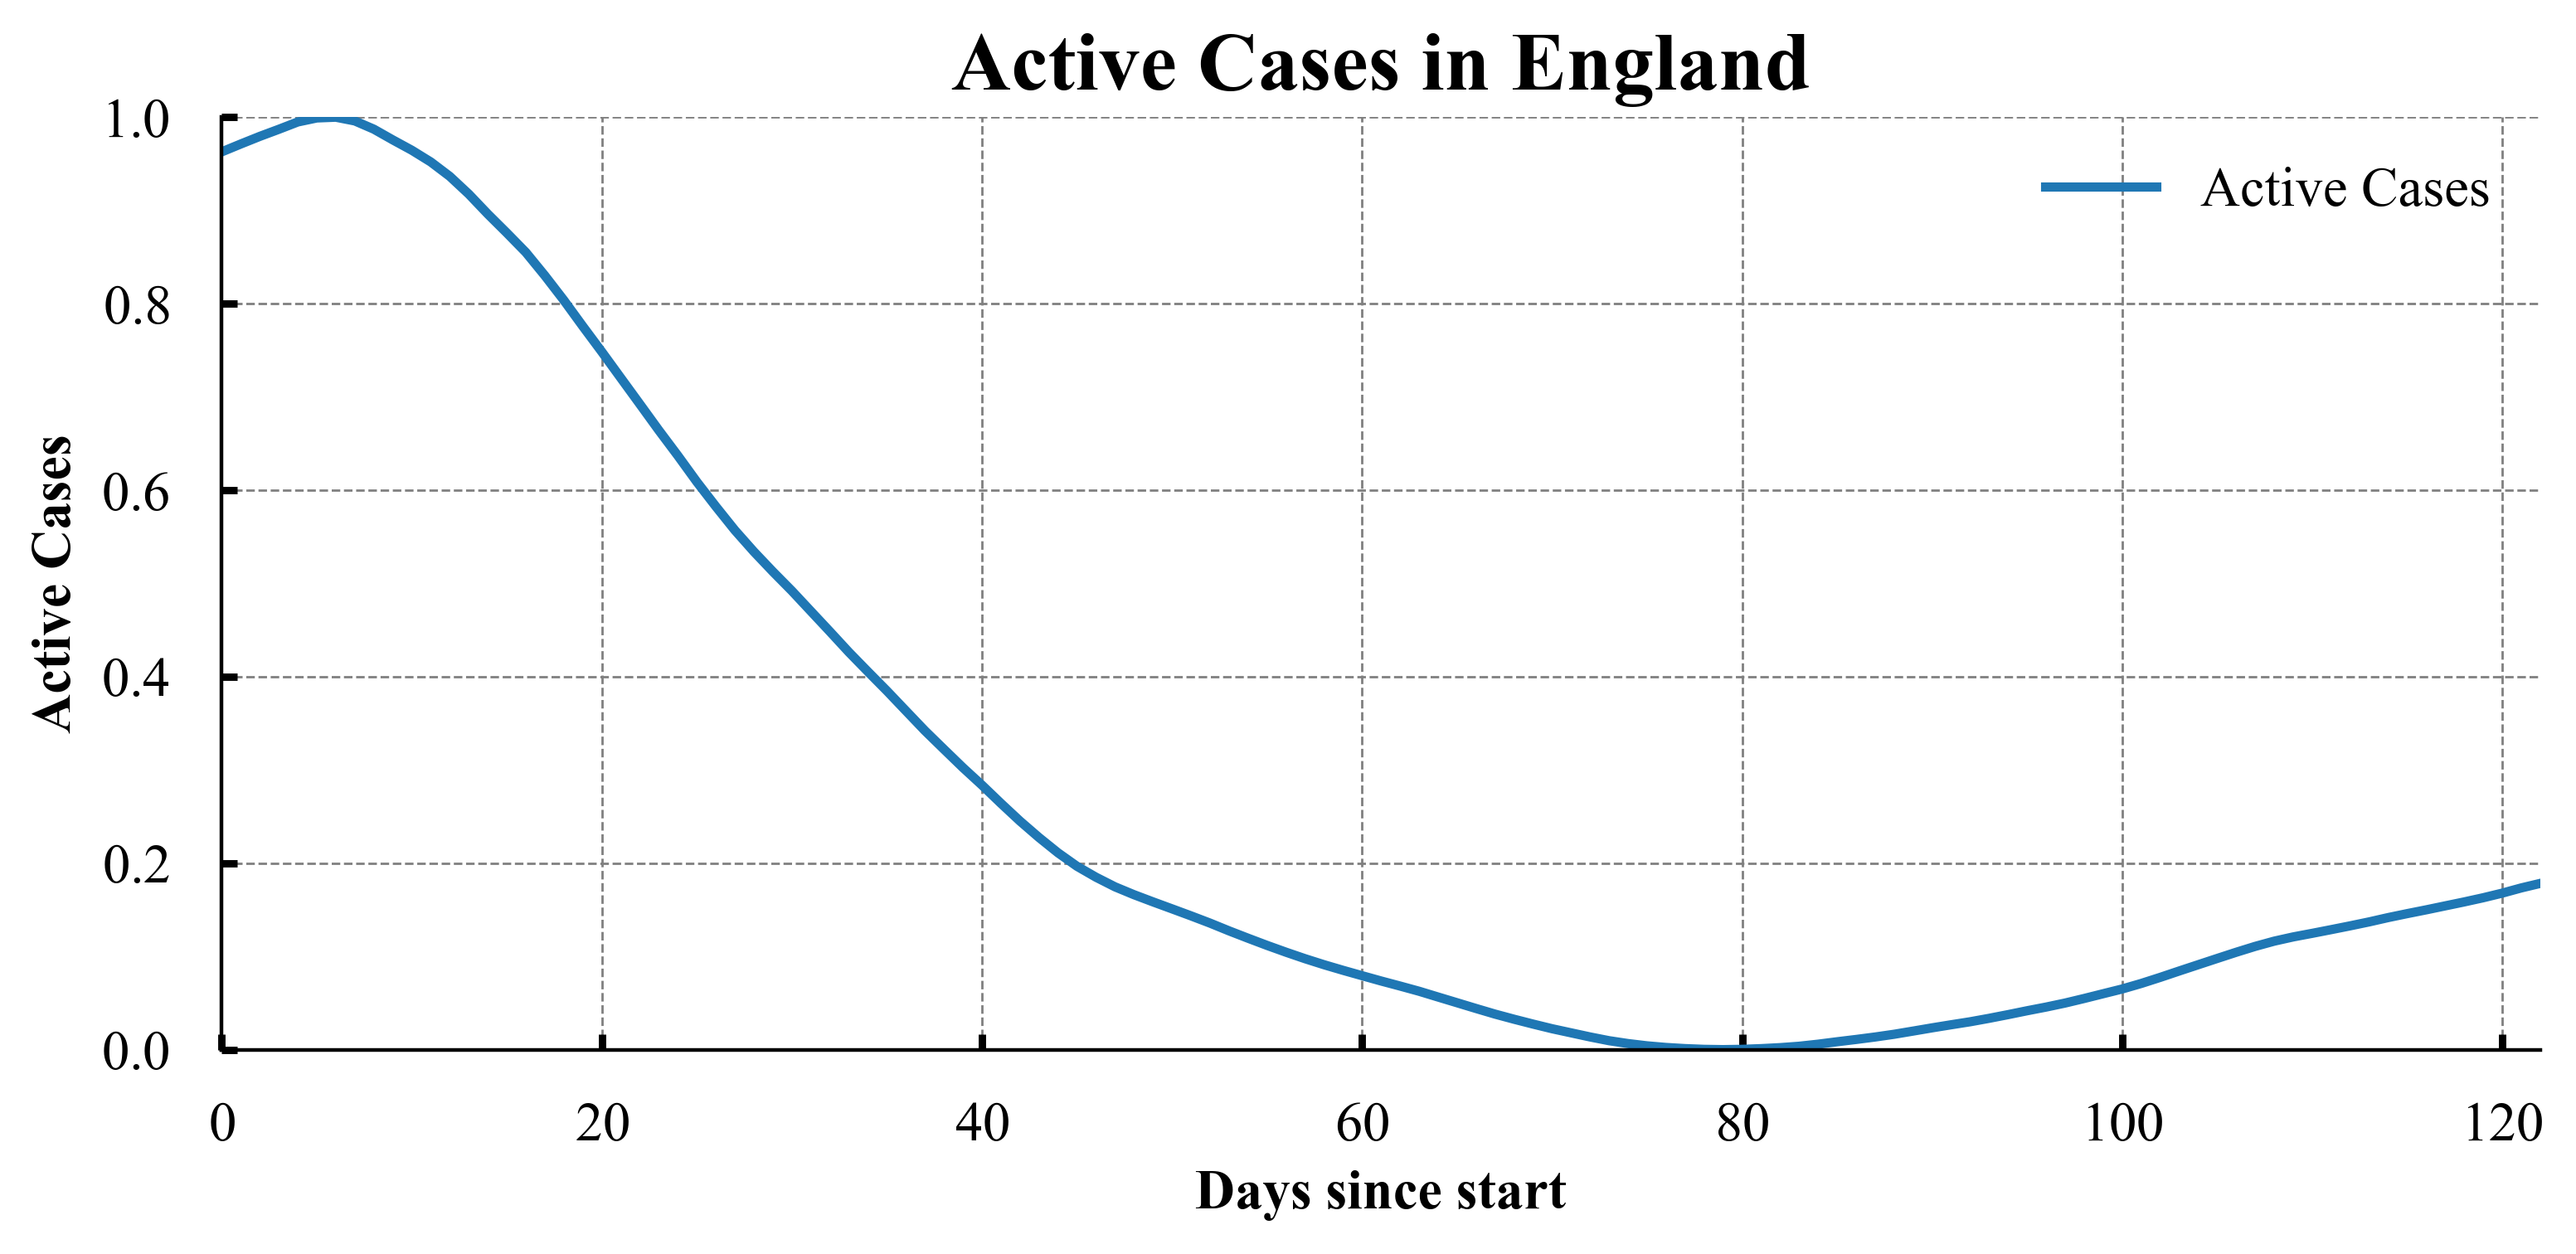

In [10]:
# plot I_train for the period available
plt.plot(I_train.cpu().detach().numpy(), label="Active Cases")
plt.title("Active Cases in England")
plt.xlabel("Days since start")
plt.ylabel("Active Cases")
plt.legend()
plt.show()

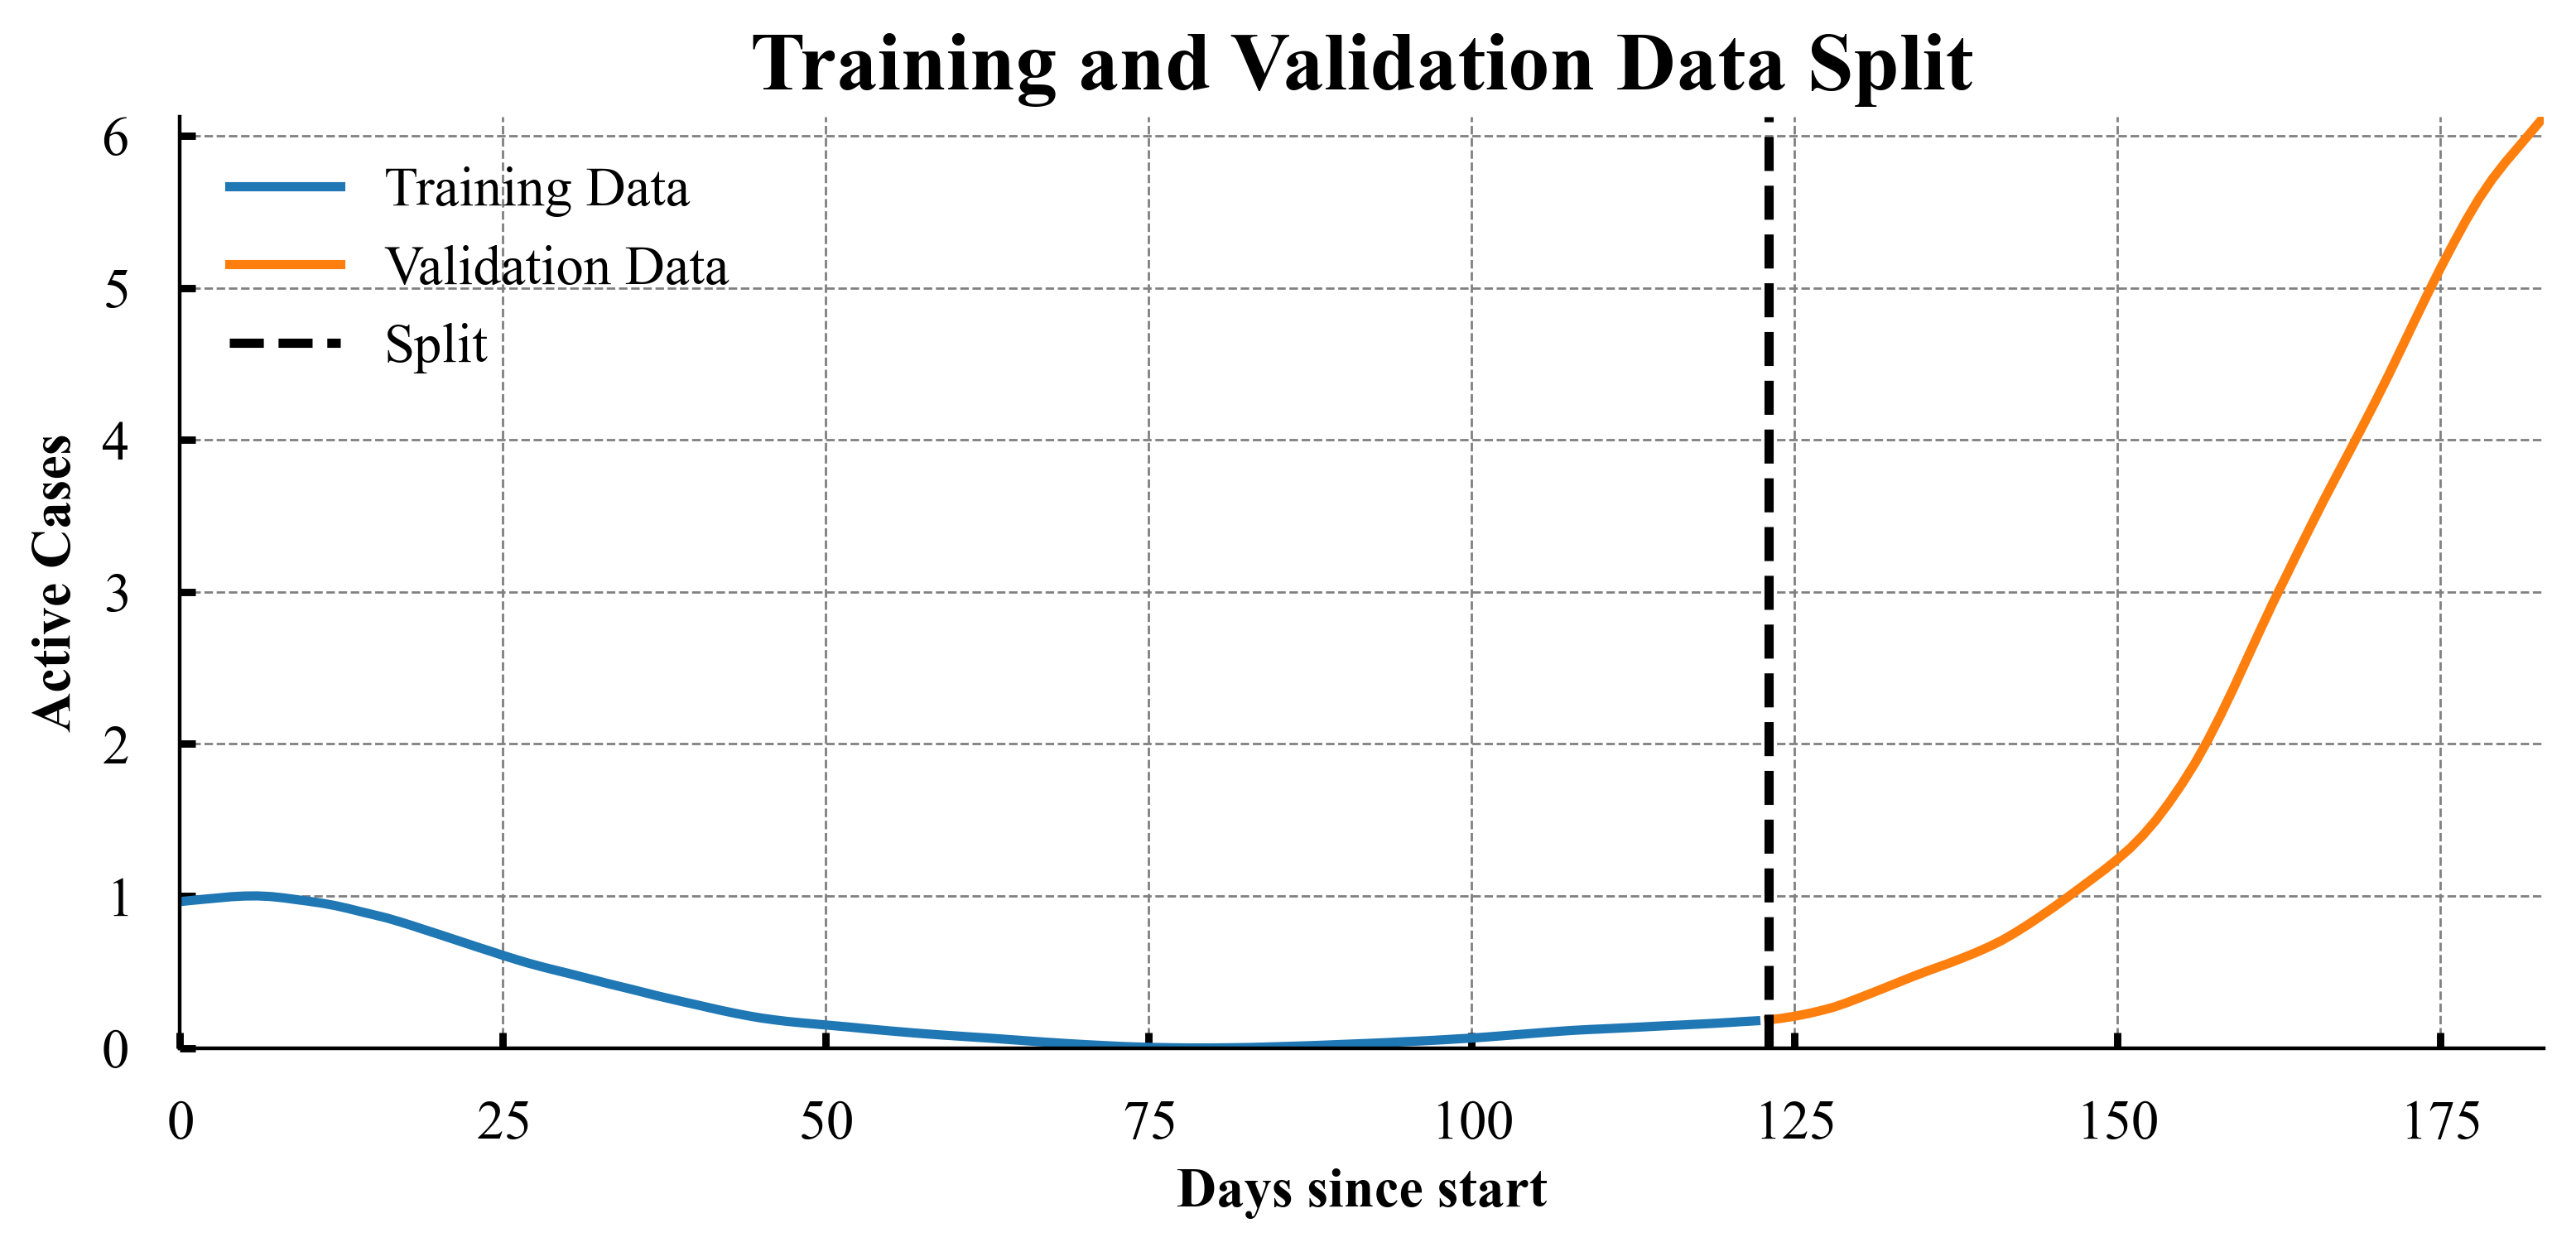

In [11]:
# plot the training data and validation data and show the split as a labeled straight dotted line
plt.plot(I_train.cpu().detach().numpy(), label="Training Data")
plt.plot(
    range(len(I_train), len(I_train) + len(I_val)),
    I_val.cpu().detach().numpy(),
    label="Validation Data",
)
plt.axvline(x=len(I_train), color="black", linestyle="--", label="Split")
plt.title("Training and Validation Data Split")
plt.xlabel("Days since start")
plt.ylabel("Active Cases")
plt.legend()
plt.show()

In [12]:
# define the neural network for epi-net
class EpiNet(nn.Module):
    def __init__(self, num_layers=2, hidden_neurons=10, output_size=5):
        super(EpiNet, self).__init__()
        self.retain_seed = 100
        torch.manual_seed(self.retain_seed)

        # Initialize layers array starting with input layer
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]

        # Append hidden layers
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])

        # Append output layer
        layers.append(nn.Linear(hidden_neurons, output_size))  # Epidemiological outputs

        # Convert list of layers to nn.Sequential
        self.net = nn.Sequential(*layers)

        # Initialize weights
        self.init_xavier()

    def forward(self, t):
        return self.net(t)

    def init_xavier(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_normal_(layer.weight, gain=g)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)

        self.net.apply(init_weights)

In [13]:
# define the neural network for beta parameter estimation
class BetaNet(nn.Module):
    def __init__(self, num_layers=2, hidden_neurons=10):
        super(BetaNet, self).__init__()
        self.retain_seed = 100
        torch.manual_seed(self.retain_seed)

        # Initialize layers array starting with the input layer
        layers = [nn.Linear(1, hidden_neurons), nn.Tanh()]

        # Append hidden layers
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_neurons, hidden_neurons), nn.Tanh()])

        # Append output layer
        layers.append(
            nn.Linear(hidden_neurons, 1)
        )  # Output layer for estimating infection rate β

        # Convert list of layers to nn.Sequential
        self.net = nn.Sequential(*layers)

        # Initialize weights
        self.init_xavier()

    def forward(self, t):
        # Forward pass to compute β
        return self.get_params(t)

    def init_xavier(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                g = nn.init.calculate_gain("tanh")
                nn.init.xavier_normal_(layer.weight, gain=g)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)

        self.net.apply(init_weights)

    def get_params(self, t):
        # Ensure beta (β) is a positive value between 0 and 1 using the sigmoid function
        beta = torch.sigmoid(self.net(t))
        return beta

In [35]:
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau


def pinn_loss(tensor_data, beta_net, model_output, t, N, device):
    I, H, C, R, D = tensor_data.unbind(1)

    # Calculate the predicted derivatives
    S = N - I - H - C - R - D
    S_pred = -beta_net(t) * S * I / N

    # Using grad outputs need to be of size [batch_size], not [batch_size, 1]
    S = S.view(-1)
    I_pred, H_pred, C_pred, R_pred, D_pred = model_output.unbind(1)
    I_pred, H_pred, C_pred, R_pred, D_pred = (
        I_pred.view(-1),
        H_pred.view(-1),
        C_pred.view(-1),
        R_pred.view(-1),
        D_pred.view(-1),
    )

    # Compute gradients
    s_t = grad(S_pred.sum(), t, create_graph=True)[0]
    i_t = grad(I_pred.sum(), t, create_graph=True)[0]
    h_t = grad(H_pred.sum(), t, create_graph=True)[0]
    c_t = grad(C_pred.sum(), t, create_graph=True)[0]
    r_t = grad(R_pred.sum(), t, create_graph=True)[0]
    d_t = grad(D_pred.sum(), t, create_graph=True)[0]

    # Compute residuals
    dSdt = s_t + beta_net(t).view(-1) * S * I / N
    dIdt = i_t - beta_net(t).view(-1) * S * I / N - (gamma + alpha) * I
    dHdt = h_t - alpha * I - (gamma + delta) * H
    dCdt = c_t - gamma * H - delta * C
    dRdt = r_t - gamma * (H + I)
    dDdt = d_t - delta * (H + C)

    # Loss components
    data_loss = torch.mean(
        (I - I_pred) ** 2
        + (H - H_pred) ** 2
        + (C - C_pred) ** 2
        + (R - R_pred) ** 2
        + (D - D_pred) ** 2
    )
    physics_loss = torch.mean(dSdt**2 + dIdt**2 + dHdt**2 + dCdt**2 + dRdt**2 + dDdt**2)
    initial_condition_loss = torch.mean(
        (I[0] - I_pred[0]) ** 2
        + (H[0] - H_pred[0]) ** 2
        + (C[0] - C_pred[0]) ** 2
        + (R[0] - R_pred[0]) ** 2
        + (D[0] - D_pred[0]) ** 2
    )

    # Total loss
    loss = data_loss + physics_loss + initial_condition_loss
    return loss

In [36]:
def train_model(
    model,
    beta_net,
    tensor_data,
    t_train,
    optimizer,
    N,
    num_epochs=1000,
    device="cpu",
    print_every=100,
):
    model.to(device)
    beta_net.to(device)
    tensor_data = tensor_data.to(device)

    loss_history = []
    # Ensure t is correctly defined and requires grad
    t = t_train.requires_grad_(True)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        model_output = model(t)
        loss = pinn_loss(tensor_data, beta_net, model_output, t, N, device)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Store loss value
        loss_history.append(loss.item())

        # Print statements
        if epoch % print_every == 0:
            print(f"Epoch {epoch} - Loss: {loss.item()}")

    return model, loss_history

In [37]:
# Define the model and beta net
model = EpiNet(num_layers=2, hidden_neurons=10, output_size=5).to(device)
beta_net = BetaNet(num_layers=2, hidden_neurons=10).to(device)

In [38]:
# Define the optimizer
lr = 1e-3
optimizer = optim.Adam(list(model.parameters()) + list(beta_net.parameters()), lr=lr)

# Define the parameters
N = 1e6
gamma = 0.1
delta = 0.01
alpha = 0.05

# Train the model
model, loss_history = train_model(
    model,
    beta_net,
    tensor_data,
    t_train,
    optimizer,
    N,
    num_epochs=10000,
    device=device,
    print_every=100,
)

# Define the initial conditions
I0 = I_train[0].item()
H0 = H_train[0].item()
C0 = C_train[0].item()
R0 = R_train[0].item()
D0 = D_train[0].item()

Epoch 0 - Loss: 17.444528579711914
Epoch 100 - Loss: 2.1180660724639893
Epoch 200 - Loss: 0.3756304383277893
Epoch 300 - Loss: 0.10831055045127869
Epoch 400 - Loss: 0.06842342764139175
Epoch 500 - Loss: 0.05536656081676483
Epoch 600 - Loss: 0.048334527760744095
Epoch 700 - Loss: 0.0439796969294548
Epoch 800 - Loss: 0.04109489917755127
Epoch 900 - Loss: 0.03899502754211426
Epoch 1000 - Loss: 0.03731623291969299
Epoch 1100 - Loss: 0.03588179871439934
Epoch 1200 - Loss: 0.03460574895143509
Epoch 1300 - Loss: 0.03344334289431572
Epoch 1400 - Loss: 0.03237207978963852
Epoch 1500 - Loss: 0.031385764479637146
Epoch 1600 - Loss: 0.030490774661302567
Epoch 1700 - Loss: 0.029698973521590233
Epoch 1800 - Loss: 0.029018212109804153
Epoch 1900 - Loss: 0.028445769101381302
Epoch 2000 - Loss: 0.02796843834221363
Epoch 2100 - Loss: 0.02756764180958271
Epoch 2200 - Loss: 0.02722492627799511
Epoch 2300 - Loss: 0.02692471817135811
Epoch 2400 - Loss: 0.02665575034916401
Epoch 2500 - Loss: 0.02640937082469

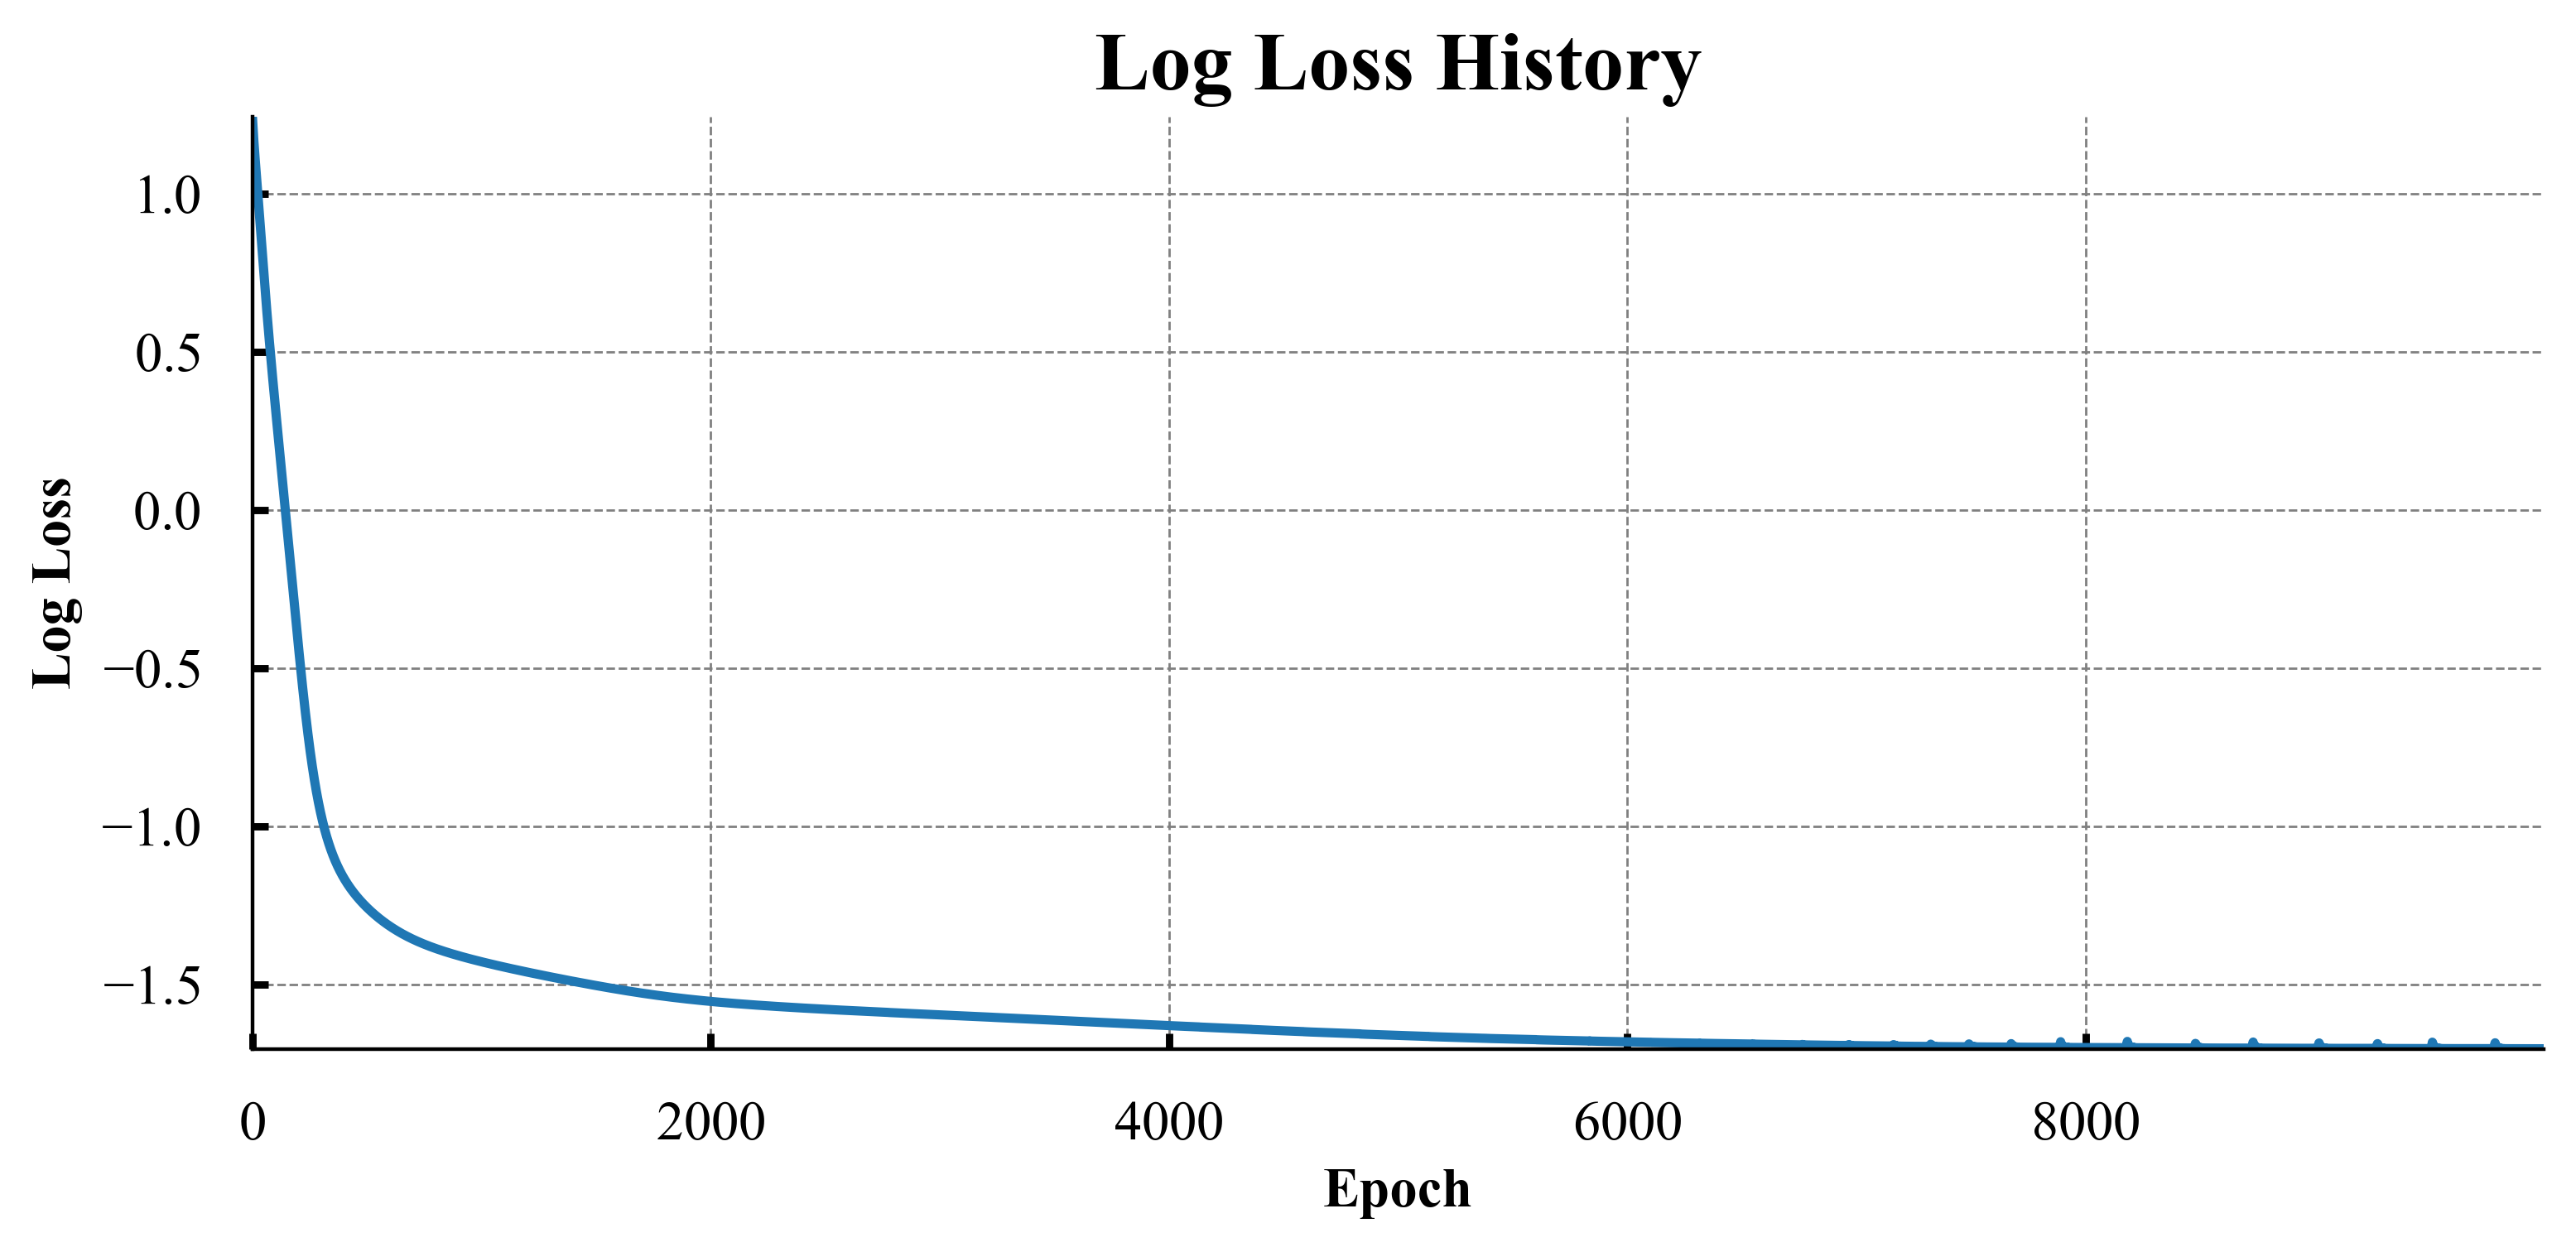

In [48]:
# plot the loss history in base 10
plt.plot(np.log10(loss_history))
plt.title("Log Loss History")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()


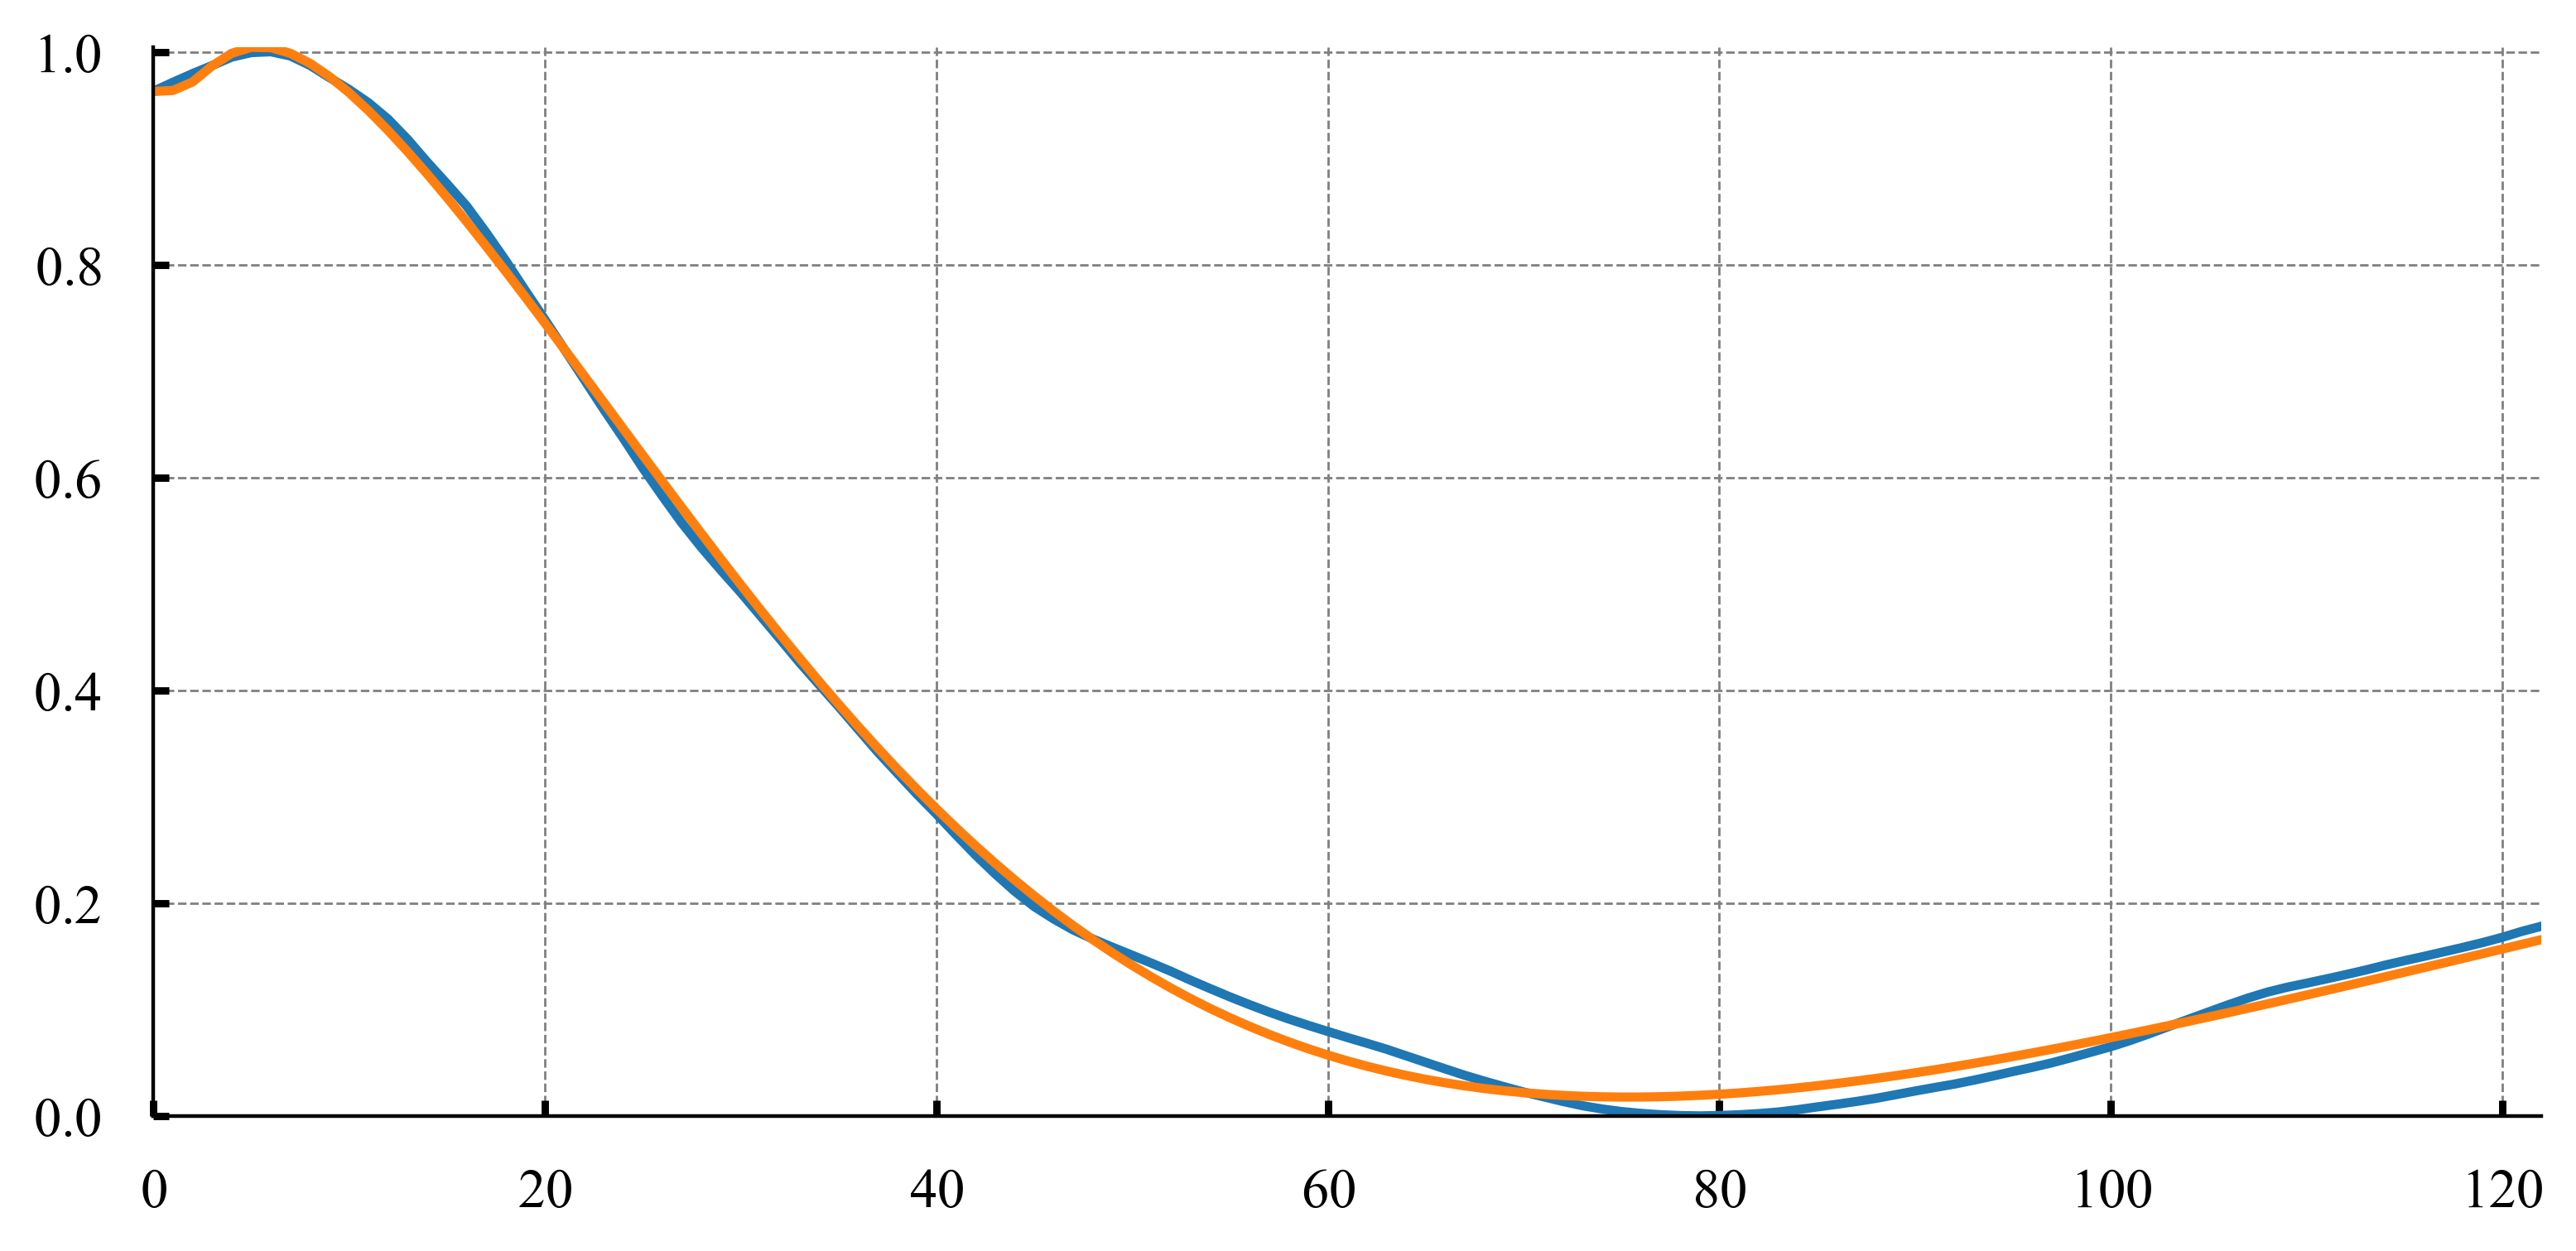

In [43]:
# plot the actual and predicted of the training data
model.eval()
with torch.no_grad():
    t = t_train
    I_pred, H_pred, C_pred, R_pred, D_pred = model(t).unbind(1)
    
    # plot the actual and predicted of the training data
    plt.plot(I_train.cpu().detach().numpy(), label="Actual Active Cases")
    plt.plot(I_pred.cpu().detach().numpy(), label="Predicted Active Cases")
    
    

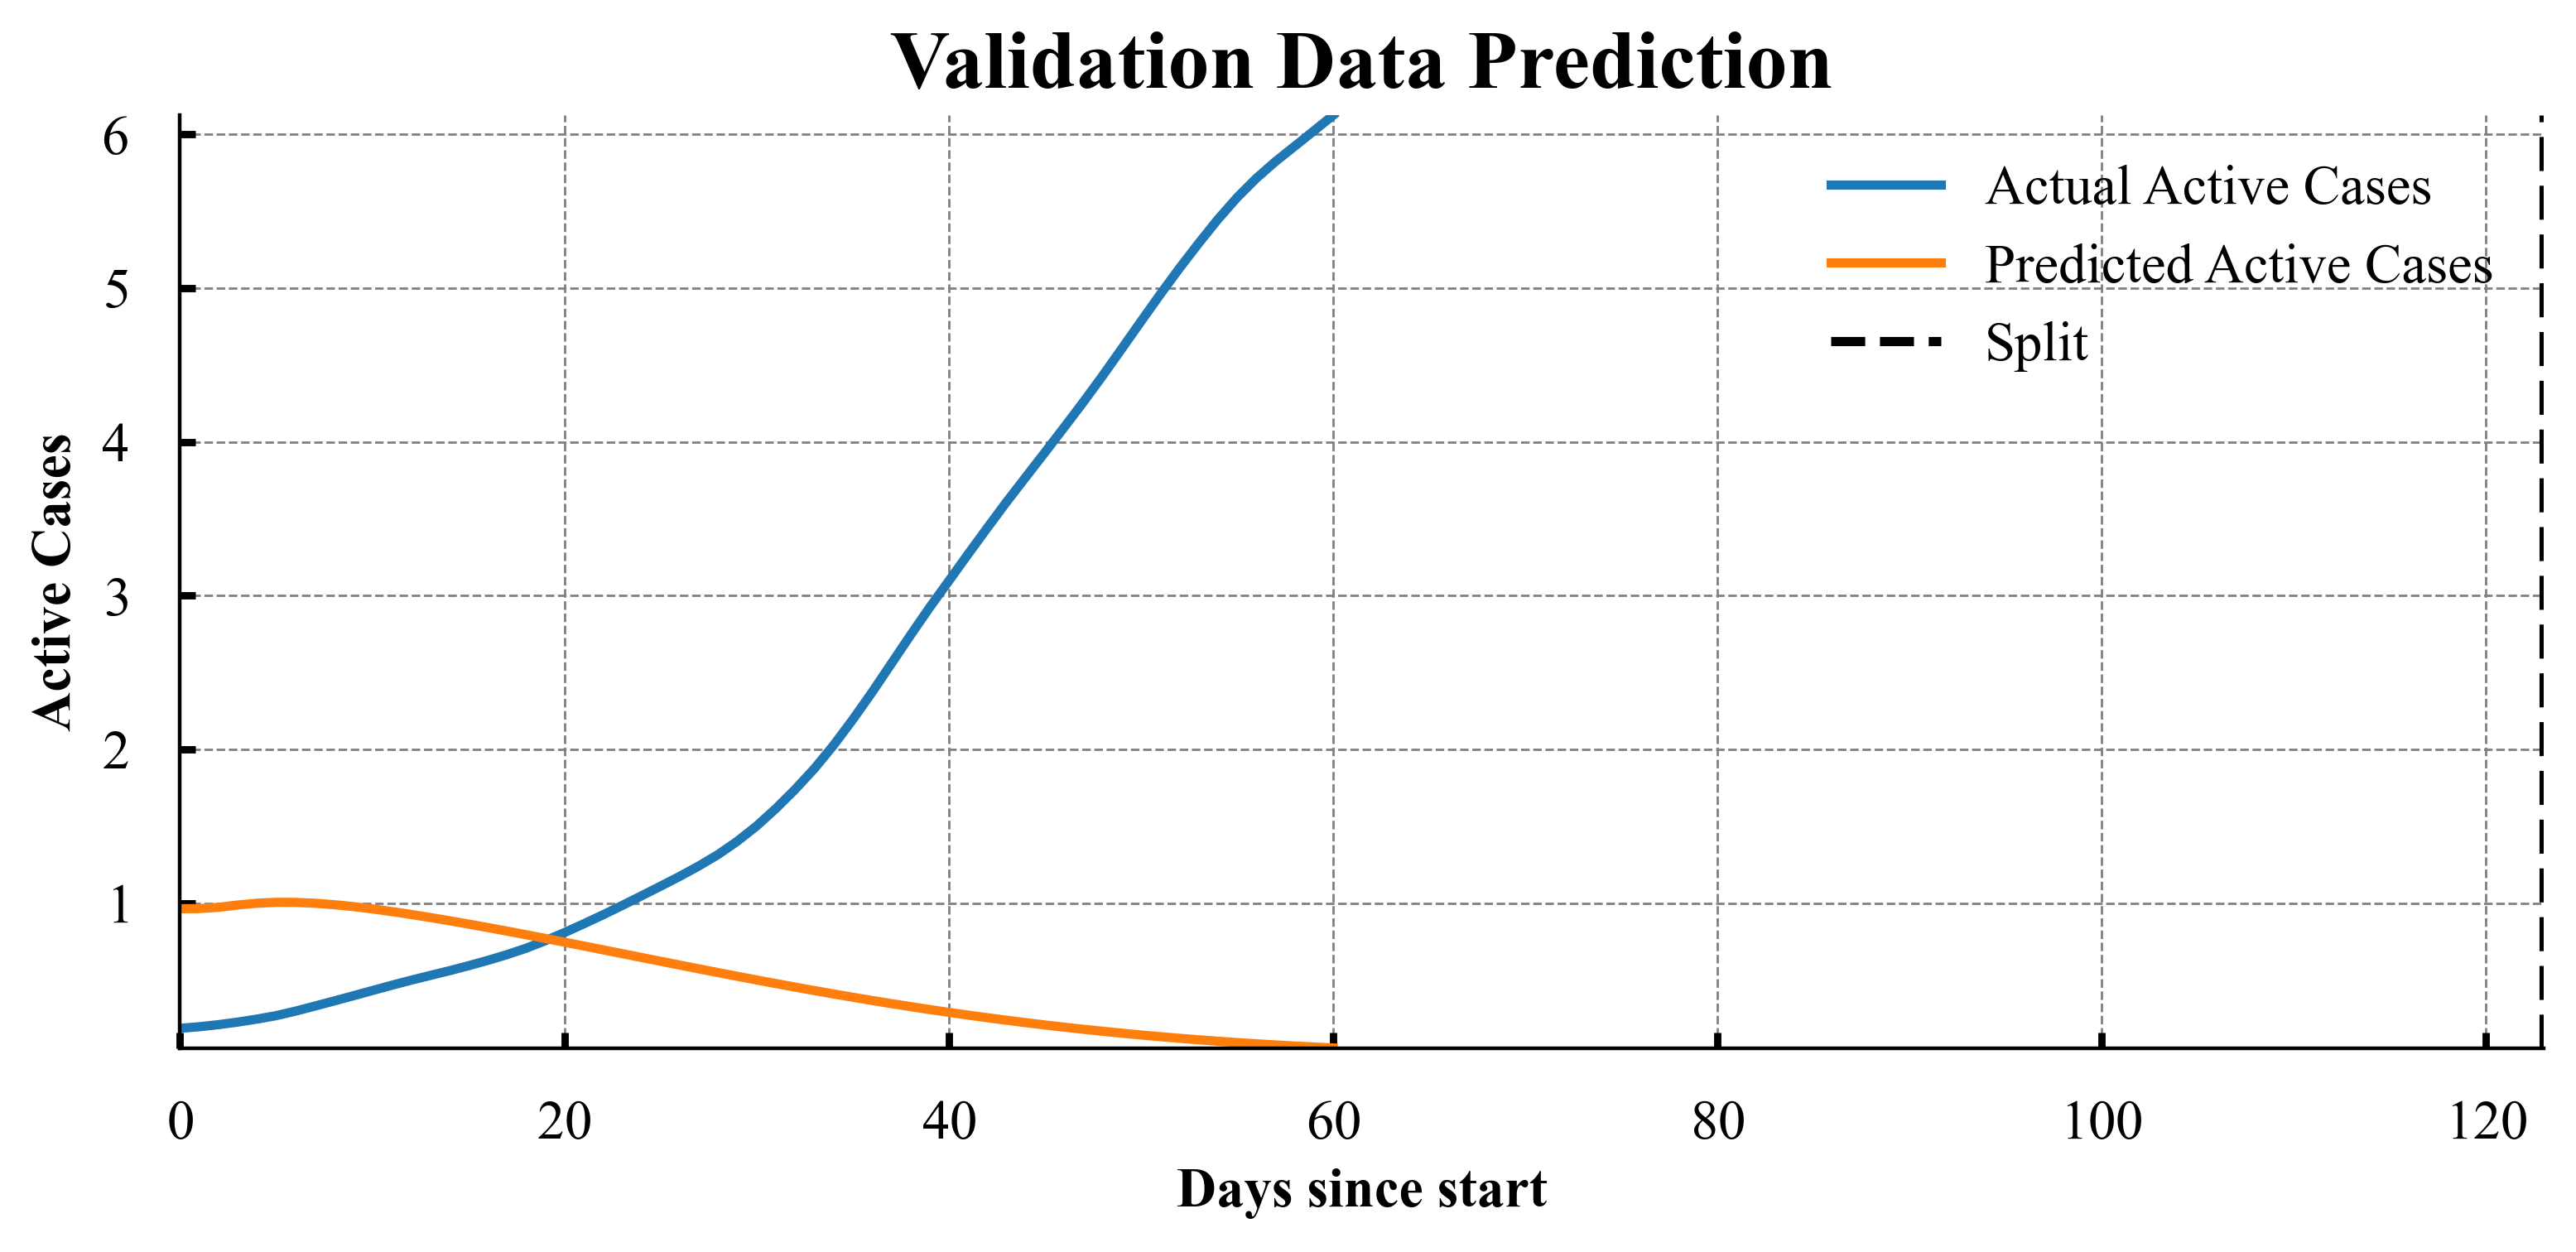

In [47]:
# write the code to predict the validation data from the point where the training data ends show where the training data ends and the validation data starts
mo

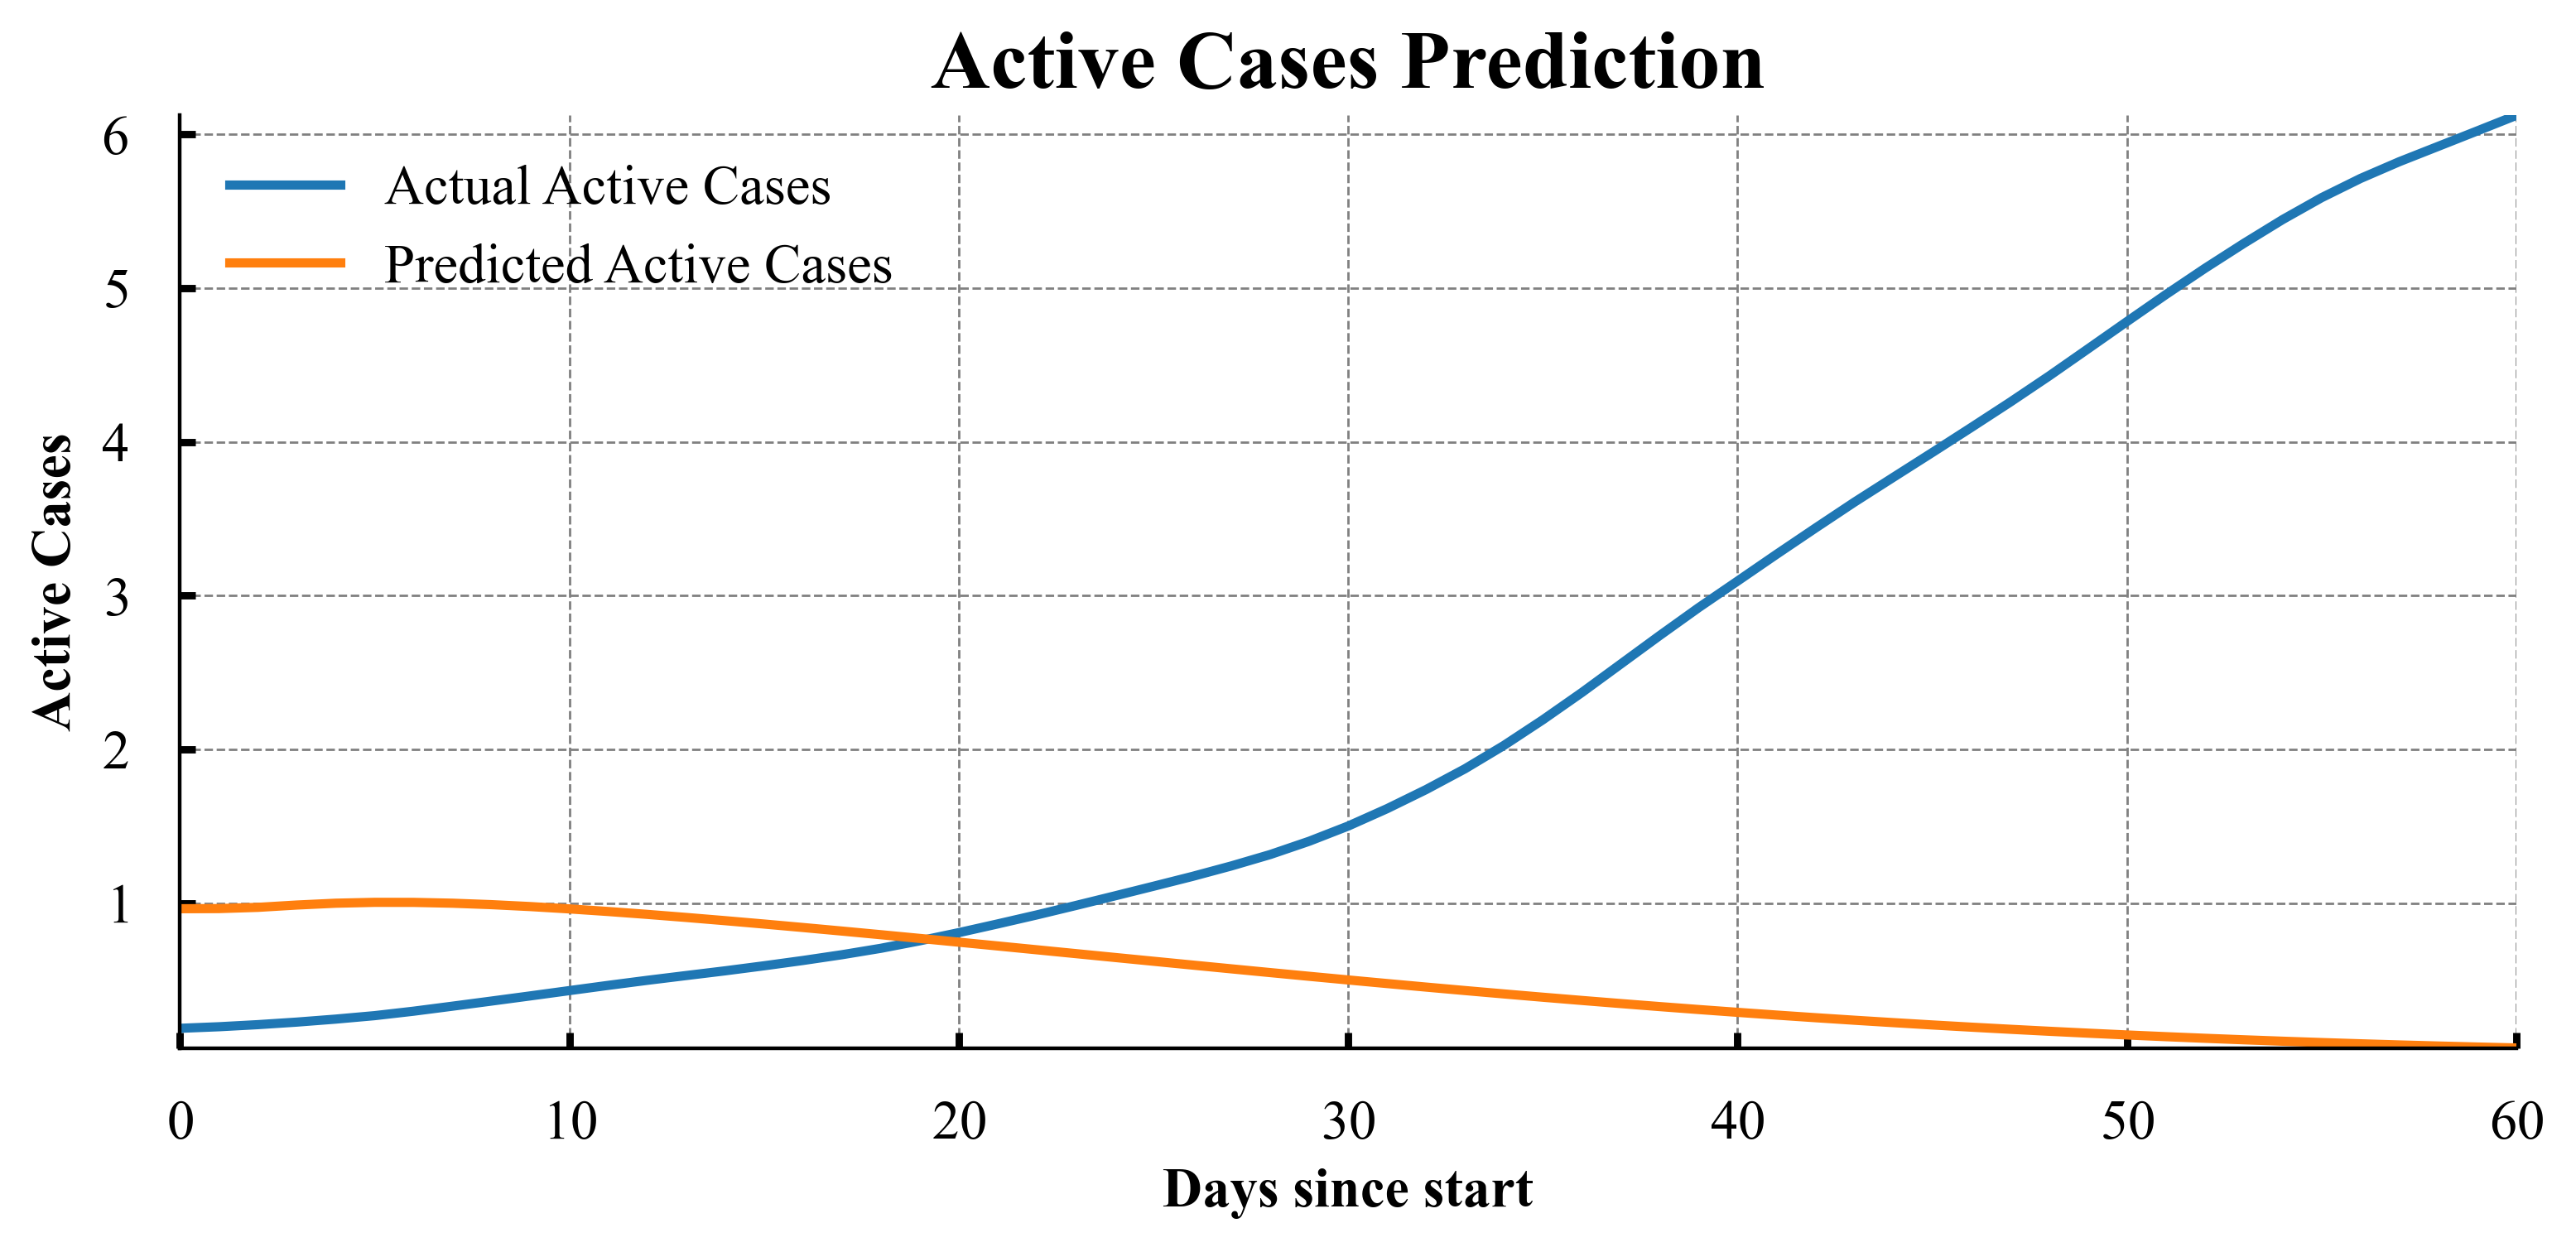

In [45]:
# predict the model
def predict_model(model, beta_net, t, N, device):
    model.eval()
    beta_net.eval()
    
    # Ensure t is correctly defined and requires grad
    t = t
    
    # Forward pass
    model_output = model(t)
    
    # Calculate the predicted derivatives
    S = N - model_output[:, 0].view(-1) - model_output[:, 1].view(-1) - model_output[:, 2].view(-1) - model_output[:, 3].view(-1) - model_output[:, 4].view(-1)
    S_pred = -beta_net(t) * S * model_output[:, 0].view(-1) / N
    
    # Using grad outputs need to be of size [batch_size], not [batch_size, 1]
    S = S.view(-1)
    I_pred, H_pred, C_pred, R_pred, D_pred = model_output.unbind(1)
    I_pred, H_pred, C_pred, R_pred, D_pred = I_pred.view(-1), H_pred.view(-1), C_pred.view(-1), R_pred.view(-1), D_pred.view(-1)
    
    # Compute gradients
    s_t = grad(S_pred.sum(), t, create_graph=True)[0]
    i_t = grad(I_pred.sum(), t, create_graph=True)[0]
    h_t = grad(H_pred.sum(), t, create_graph=True)[0]
    c_t = grad(C_pred.sum(), t, create_graph=True)[0]
    r_t = grad(R_pred.sum(), t, create_graph=True)[0]
    d_t = grad(D_pred.sum(), t, create_graph=True)[0]
    
    # Compute residuals
    dSdt = s_t + beta_net(t).view(-1) * S * model_output[:, 0].view(-1) / N
    dIdt = i_t - beta_net(t).view(-1) * S * model_output[:, 0].view(-1) / N - (gamma + alpha) * I_pred
    dHdt = h_t - alpha * I_pred - (gamma + delta) * H_pred
    dCdt = c_t - gamma * H_pred - delta * C_pred
    dRdt = r_t - gamma * (H_pred + I_pred)
    dDdt = d_t - delta * (H_pred + C_pred)
    
    return model_output, dSdt, dIdt, dHdt, dCdt, dRdt, dDdt

# Predict the model
model_output, dSdt, dIdt, dHdt, dCdt, dRdt, dDdt = predict_model(model, beta_net, t_val, N, device)

# Calculate the predicted derivatives
S = N - model_output[:, 0].view(-1) - model_output[:, 1].view(-1) - model_output[:, 2].view(-1) - model_output[:, 3].view(-1) - model_output[:, 4].view(-1)

# Calculate the predicted derivatives
S_pred = -beta_net(t_val) * S * model_output[:, 0].view(-1) / N

# Using grad outputs need to be of size [batch_size], not [batch_size, 1]
S = S.view(-1)

# Compute gradients
s_t = grad(S_pred.sum(), t_val, create_graph=True)[0]

# Compute residuals
dSdt = s_t + beta_net(t_val).view(-1) * S * model_output[:, 0].view(-1) / N

# plot the predicted values
plt.plot(I_val.cpu().detach().numpy(), label="Actual Active Cases")
plt.plot(model_output[:, 0].cpu().detach().numpy(), label="Predicted Active Cases")
plt.title("Active Cases Prediction")
plt.xlabel("Days since start")
plt.ylabel("Active Cases")
plt.legend()
plt.show()
    
    
    
    
    

In [51]:
def pinn_loss(tensor_data, beta_net, model_output, t, N, device):
    # Unpack the tensor data
    I, H, C, R, D = (
        tensor_data[:, 0],
        tensor_data[:, 1],
        tensor_data[:, 2],
        tensor_data[:, 3],
        tensor_data[:, 4],
    )

    # unpack the model output
    I_pred, H_pred, C_pred, R_pred, D_pred = (
        model_output[:, 0],
        model_output[:, 1],
        model_output[:, 2],
        model_output[:, 3],
        model_output[:, 4],
    )

    # Calculate the predicted derivatives w.r.t. time
    # S data and S_pred at time t
    # Calculate the predicted derivatives
    S = N - I - H - C - R - D
    S_pred = -beta_net(t) * S * I / N

    # Using grad outputs need to be of size [batch_size], not [batch_size, 1]
    S = S.view(-1)

    s_t = torch.autograd.grad(S_pred, t, torch.ones_like(t), create_graph=True)[0]
    i_t = torch.autograd.grad(I_pred, t, torch.ones_like(t), create_graph=True)[0]
    h_t = torch.autograd.grad(H_pred, t, torch.ones_like(t), create_graph=True)[0]
    c_t = torch.autograd.grad(C_pred, t, torch.ones_like(t), create_graph=True)[0]
    r_t = torch.autograd.grad(R_pred, t, torch.ones_like(t), create_graph=True)[0]
    d_t = torch.autograd.grad(D_pred, t, torch.ones_like(t), create_graph=True)[0]

    # Calculate the residuals
    dSdt = s_t + beta_net(t) * S * I / N
    dIdt = i_t - beta_net(t) * S * I / N - (gamma + alpha) * I
    dHdt = h_t - alpha * I - (gamma + delta) * H
    dCdt = c_t - gamma * H - delta * C
    dRdt = r_t - gamma * (H + I)
    dDdt = d_t - delta * (H + C)

    # data loss
    data_loss = torch.mean(
        (I - I_pred) ** 2
        + (H - H_pred) ** 2
        + (C - C_pred) ** 2
        + (R - R_pred) ** 2
        + (D - D_pred) ** 2
    )

    # physics loss
    physics_loss = torch.mean(dSdt**2 + dIdt**2 + dHdt**2 + dCdt**2 + dRdt**2 + dDdt**2)

    # initial condition loss
    initial_condition_loss = torch.mean(
        (I[0] - I_pred[0]) ** 2
        + (H[0] - H_pred[0]) ** 2
        + (C[0] - C_pred[0]) ** 2
        + (R[0] - R_pred[0]) ** 2
        + (D[0] - D_pred[0]) ** 2
    )

    # total loss
    loss = data_loss + physics_loss + initial_condition_loss

    return loss

In [52]:
# define the training loop
def train_model(
    tensor_data,
    beta_model,
    epi_model,
    N,
    device,
    num_epochs=1000,
    learning_rate=1e-3,
):
    # Define the optimizer for the beta net
    beta_optimizer = optim.Adam(beta_model.parameters(), lr=learning_rate)

    # Define the optimizer for the epi net
    epi_optimizer = optim.Adam(epi_model.parameters(), lr=learning_rate)

    # log the loss values
    loss_values = []

    for epoch in tqdm(range(num_epochs)):

        # forward pass: predict the beta value and the epidemiological outputs
        epi_model.train()
        beta_model.train()

        beta = beta_model(t_train)
        model_output = epi_model(t_train)

        # calculate the loss
        loss = pinn_loss(tensor_data, beta, model_output, t_train, N, device)

        # backward pass: calculate the gradients
        beta_optimizer.zero_grad()
        epi_optimizer.zero_grad()
        loss.backward()

        # update the weights
        beta_optimizer.step()
        epi_optimizer.step()

        # log the loss value
        loss_values.append(loss.item())

        # print the loss value every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch} Loss: {loss.item():.4f}")

    return beta_model, epi_model, loss_values

In [53]:
# define the hyperparameters
num_layers = 2
hidden_neurons = 10
num_epochs = 1000
learning_rate = 1e-3

# initialize the beta model
beta_model = BetaNet(num_layers=num_layers, hidden_neurons=hidden_neurons).to(device)

# initialize the epi model
epi_model = EpiNet(
    num_layers=num_layers, hidden_neurons=hidden_neurons, output_size=5
).to(device)

In [54]:
N = 1e6
gamma = 0.1
delta = 0.01
alpha = 0.05

# train the model
beta_model, epi_model, loss_values = train_model(
    tensor_data,
    beta_model,
    epi_model,
    N,
    device,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: 'Tensor' object is not callable